In [ ]:
import io
import os
from PIL import Image
import torch
from torchvision import transforms
from datasets import load_dataset, Dataset

def transform_format(example):
    return {
        "id": example["id"],
        "image": example["image"],
        "Question": example["conversations"][0]["value"],
        "Answer": example["conversations"][1]["value"],
    }

def load_images_as_pil(dataset, image_dir):
    updated_entries = []
    for example in dataset:
        image_path = os.path.join(image_dir, example["image"])
        try:
            pil_image = Image.open(image_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            pil_image = None
        updated_entries.append({
            "image": pil_image,
            "Question": example["Question"],
            "Answer": example["Answer"],
        })
    return updated_entries

def pil_image_to_bytes(image):
    buf = io.BytesIO()
    image.save(buf, format='JPEG')
    return buf.getvalue()

def bytes_to_pil_image(byte_data):
    return Image.open(io.BytesIO(byte_data))

# Load datasets
validate_json_path = "./Inference data comprised 40% of the dataset.json"
dataset = load_dataset("json", data_files={"train": validate_json_path})
dataset = dataset.map(transform_format)["train"]

# Load images
image_dir = "Demoface"
dataset = load_images_as_pil(dataset, image_dir)

data_dict = {
    "image": [bytes_to_pil_image(pil_image_to_bytes(item["image"])) for item in dataset],
    "Question": [item["Question"] for item in dataset],
    "Answer": [item["Answer"] for item in dataset],
}

dataset = Dataset.from_dict(data_dict)
print(dataset[0])


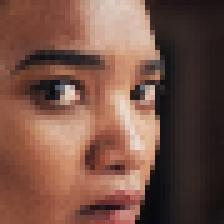

In [ ]:
dataset[0]["image"]

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch
from torch.nn.utils.rnn import pad_sequence
from PIL import Image
import io


def bytes_to_pil_image(byte_data):
    return Image.open(io.BytesIO(byte_data))


class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.processor(images=item["image"] , padding="max_length", return_tensors="pt")
        # remove batch dimension
        encoding = {k: v.squeeze() for k, v in encoding.items()}
        litem=item['Answer']
        litem=litem.split(',')[-2]+litem.split(',')[-1]
        encoding["text"] = litem
        encoding["question"] = item['Question']
        return encoding


import torch
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    processed_batch = {}

    # Process image encodings
    for key in batch[0].keys():
        if key not in ["text", "question"]:
            processed_batch[key] = torch.stack([example[key] for example in batch])

    # Process questions
    question_inputs = processor.tokenizer(
        [example["question"] for example in batch], padding=True, return_tensors="pt"
    )
    processed_batch["question_input_ids"] = question_inputs["input_ids"]
    processed_batch["question_attention_mask"] = question_inputs["attention_mask"]

    # Process answers (text)
    text_inputs = processor.tokenizer(
        [example["text"] for example in batch], padding=True, return_tensors="pt"
    )
    processed_batch["input_ids"] = text_inputs["input_ids"]
    processed_batch["attention_mask"] = text_inputs["attention_mask"]

    return processed_batch



In [ ]:
from peft import LoraConfig, get_peft_model
from transformers import AutoProcessor, Blip2ForConditionalGeneration, BitsAndBytesConfig

quant_config = BitsAndBytesConfig(load_in_8bit=True)

# Load from local path
processor = AutoProcessor.from_pretrained("./blip2_local_downloaded_path")
model = Blip2ForConditionalGeneration.from_pretrained("./blip2_local_downloaded_path", device_map="cuda:1", quantization_config=quant_config)

# Define LoraConfig
config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    target_modules=["q_proj", "k_proj"]
)

model = get_peft_model(model, config)
model.print_trainable_parameters()

train_dataset = ImageCaptioningDataset(dataset, processor)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=6, collate_fn=collate_fn)

device = "cuda:1" if torch.cuda.is_available() else "cpu"
model.to(device)


Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.


trainable params: 5,242,880 || all params: 3,749,922,816 || trainable%: 0.1398


PeftModel(
  (base_model): LoraModel(
    (model): Blip2ForConditionalGeneration(
      (vision_model): Blip2VisionModel(
        (embeddings): Blip2VisionEmbeddings(
          (patch_embedding): Conv2d(3, 1408, kernel_size=(14, 14), stride=(14, 14))
        )
        (encoder): Blip2Encoder(
          (layers): ModuleList(
            (0-38): 39 x Blip2EncoderLayer(
              (self_attn): Blip2Attention(
                (dropout): Dropout(p=0.0, inplace=False)
                (qkv): Linear8bitLt(in_features=1408, out_features=4224, bias=True)
                (projection): Linear8bitLt(in_features=1408, out_features=1408, bias=True)
              )
              (layer_norm1): LayerNorm((1408,), eps=1e-05, elementwise_affine=True)
              (mlp): Blip2MLP(
                (activation_fn): GELUActivation()
                (fc1): Linear8bitLt(in_features=1408, out_features=6144, bias=True)
                (fc2): Linear8bitLt(in_features=6144, out_features=1408, bias=True)
      

In [ ]:
import torch
import bitsandbytes as bnb

# model.to("cuda:1")
save_path="fine_tuned_blip2_epoch_75.pth"
# Load checkpoint
checkpoint = torch.load(save_path, map_location="cuda:1")

# Load state dict properly
model.load_state_dict(checkpoint["model_state_dict"], strict=True)

print("Quantized model loaded successfully!")


Quantized model loaded successfully!


In [ ]:

val_dataset = ImageCaptioningDataset(dataset, processor)
# train_dataloader = DataLoader(val_dataset, shuffle=True, batch_size=1, collate_fn=collate_fn)
dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)

device = "cuda:1" if torch.cuda.is_available() else "cpu"
# model.to(device)  # Move the model to the correct device

print(f"Total number of samples in train_dataset: {len(train_dataset)}")


Total number of samples in train_dataset: 12096


In [ ]:
import csv
import torch
from torch.utils.data import DataLoader

# Define CSV file name
csv_filename = "Blip2_predictions_75.csv"

# Set model to evaluation mode
model=model.to("cuda:1")
model.eval()

ii=0

# Open the CSV file for writing
with open(csv_filename, mode="w", newline="", encoding="utf-8") as file:
    writer = csv.writer(file)
    writer.writerow(["Ground Truth","Question with Ground Truth",  "Prediction"])  # Write header

    # Process dataset one sample at a time
    for idx, batch in enumerate(dataloader):
        # Move inputs to device
        image = batch["pixel_values"].to(device)  # (1, C, H, W)
        # print(batch)
        question = batch["question"][0]  # Extract single question
        ground_truth = batch["text"][0]  # Extract single ground truth

        # Tokenize the question
        question_inputs = processor.tokenizer(question, return_tensors="pt").to(device)

        # Generate answer
        with torch.no_grad():
            outputs = model.generate(
                pixel_values=image,
                input_ids=question_inputs["input_ids"],
                attention_mask=question_inputs["attention_mask"],
                max_length=50  # Adjust as needed
            )

        # Decode the generated answer
        predicted_answer = processor.decode(outputs[0], skip_special_tokens=True)
        print(ii,ground_truth,"--------------->",predicted_answer.split('.')[1])


        # Save results to CSV
        writer.writerow([ ground_truth, predicted_answer,predicted_answer.split('.')[1]])
        ii=ii+1
print(f"✅ Predictions saved to {csv_filename}")
